# Exploratory Data Analysis (EDA)

In this notebook, we perform exploratory data analysis to understand:

- class distributions
- missing values
- data quality issues

The data is from crpwarner.

## Imports & Configuration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import requests
from dotenv import load_dotenv
from pathlib import Path

%matplotlib inline
sns.set(style="whitegrid")


In [2]:
PATH = "../../data/external/crpwarner"
PATH_GROUND_TRUTH = f"{PATH}/groundtruth"
PATH_GROUND_HEX = f"{PATH_GROUND_TRUTH}/hex"
PATH_GROUND_SOL = f"{PATH_GROUND_TRUTH}/sol"
PATH_LARGE = f"{PATH}/large"
PATH_LARGE_SHEET = f"{PATH_LARGE}/sample"
PATH_LARGE_HEX = f"{PATH_LARGE}/hex"

## Load Dataset

In [3]:
ground_df = pd.read_excel(f"{PATH_GROUND_TRUTH}/groundTruth.xlsx", engine='openpyxl')
mint_df = pd.read_excel(f"{PATH_LARGE_SHEET}/mint.xlsx", engine='openpyxl')
leak_df = pd.read_excel(f"{PATH_LARGE_SHEET}/leak.xlsx", engine='openpyxl')
limit_df = pd.read_excel(f"{PATH_LARGE_SHEET}/limit.xlsx", engine='openpyxl')
ground_hex_file_list = [os.path.splitext(f)[0] for f in os.listdir(PATH_GROUND_HEX) if os.path.isfile(os.path.join(PATH_GROUND_HEX, f))]
ground_sol_file_list = [os.path.splitext(f)[0] for f in os.listdir(PATH_GROUND_SOL) if os.path.isfile(os.path.join(PATH_GROUND_SOL, f))]
large_hex_file_list = [os.path.splitext(f)[0] for f in os.listdir(PATH_LARGE_HEX) if os.path.isfile(os.path.join(PATH_LARGE_HEX, f))]


## Ground Truth

### Initial Inspection

In [4]:
ground_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  69 non-null     object
 1   Mint     69 non-null     int64 
 2   Leak     69 non-null     int64 
 3   Limit    69 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.3+ KB


In [5]:
ground_df.head()

,address,Mint,Leak,Limit
0,0x93023F1D3525E273F291B6f76d2F5027A39BF302,1,0,1
1,0x2753dcE37A7eDB052a77832039bcc9aA49Ad8b25,0,0,1
2,0x94b7D24552933F50A5A5705C446528806dCeA381,0,0,0
3,0xE0b9d4146AaD6936cBfcBE4dAE47e34aAb96b093,0,0,0
4,0x10f6f2b97F3aB29583D9D38BaBF2994dF7220C21,1,0,1


In [6]:
ground_df.describe()

,Mint,Leak,Limit
count,69.000000,69.000000,69.000000
mean,0.289855,0.130435,0.434783
std,0.457019,0.339248,0.499360
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


### Labels Distribution

#### Sum Each Label Column

In [7]:
label_counts = ground_df[["Mint", "Leak", "Limit"]].sum()
label_counts

Mint     20
Leak      9
Limit    30
dtype: int64

#### Bar Plot of Multi-Label Frequency

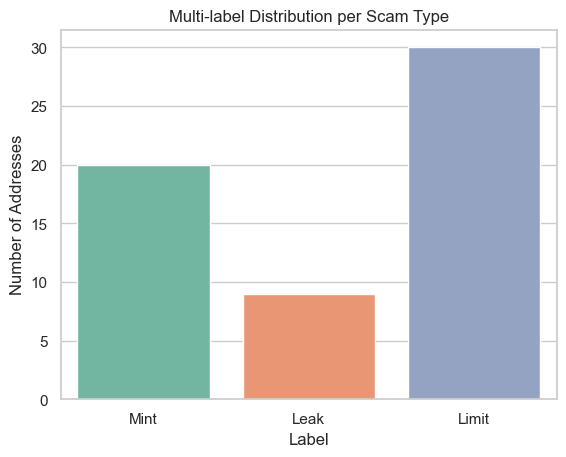

In [8]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Set2")
plt.title("Multi-label Distribution per Scam Type")
plt.xlabel("Label")
plt.ylabel("Number of Addresses")
plt.show()

#### Plot Count of Label Combinations

In [9]:
# Convert one-hot columns to label strings
def get_labels(row):
    return ','.join([
        label for label in ['Mint', 'Leak', 'Limit']
        if row[label] == 1
    ])

ground_df['label_combo'] = ground_df.apply(get_labels, axis=1)
ground_df['label_combo'] = ground_df['label_combo'].replace('', 'None')  # Replace empty with 'None'
# Count combinations
combo_counts = ground_df['label_combo'].value_counts()
combo_counts

label_combo
None               27
Limit              15
Mint,Limit         10
Mint                8
Leak,Limit          4
Leak                3
Mint,Leak           1
Mint,Leak,Limit     1
Name: count, dtype: int64

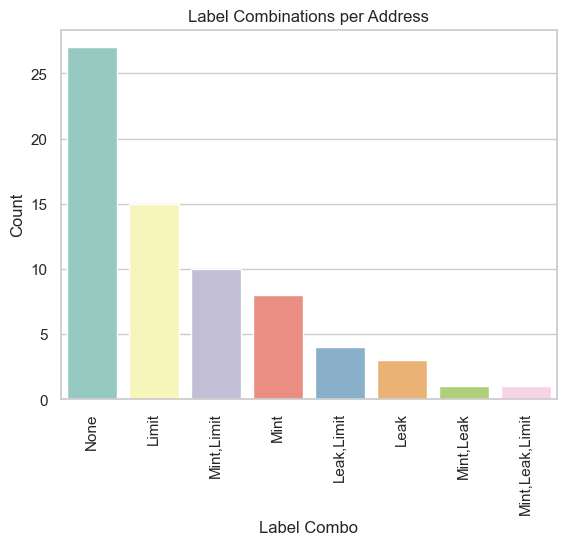

In [10]:
# Plot
sns.barplot(x=combo_counts.index, y=combo_counts.values, palette="Set3")
plt.title("Label Combinations per Address")
plt.xlabel("Label Combo")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


### Missing Values

In [11]:
ground_df.isna().sum()

address        0
Mint           0
Leak           0
Limit          0
label_combo    0
dtype: int64

In [12]:
# get the lack of hex and sol files
ground_hex_missing = set(ground_df['address']) - set(ground_hex_file_list)
ground_sol_missing = set(ground_df['address']) - set(ground_sol_file_list)
print(f"Missing HEX files: {len(ground_hex_missing)}")
print(f"Missing SOL files: {len(ground_sol_missing)}")

Missing HEX files: 0
Missing SOL files: 0


In [13]:
ground_hex_missing

set()

In [14]:
ground_sol_missing

set()

#### Get source code and bytecode

In [15]:
URL = "https://api.etherscan.io/v2/api"
project_root = Path.cwd().parents[2]
load_dotenv(os.path.join(project_root, ".env"))
api_key = os.getenv("ETHERSCAN_API_KEY")
chains = [1, 56, 97] # Ethereum, BSC Mainnet, BSC Testnet

def get_source_code(address, chain_id=1):
  params = {
    "chainid": chain_id,
    "module": "contract",
    "action": "getsourcecode",
    "address": address,
    "apikey": api_key
  }
  try:
    res = requests.get(URL, params=params).json()
    return res['result'][0] if res['status'] == '1' else None
  except Exception:
    return None

In [16]:
def get_bytecode(address, chain_id=1):
  params = {
    "chainid": chain_id,
    "module": "proxy",
    "action": "eth_getCode",
    "address": address,
    "tag": "latest",
    "apikey": api_key
  }
  try:
    res = requests.get(URL, params=params).json()
    return None if res['result'] == '0x' else res['result']
  except Exception:
    return None

In [17]:
for address in ground_sol_missing:
    for chain_id in chains:
        result = get_source_code(address, chain_id)
        if result and result["SourceCode"].strip():
            filename = f"{PATH_GROUND_SOL}/{address}.sol"
            with open(filename, "w", encoding="utf-8") as f:
                f.write(result["SourceCode"])
            print(f"Saved source code for {address} (chain {chain_id})")
            break

In [18]:
for address in ground_hex_missing:
  for chain_id in chains:
    res = get_bytecode(address, chain_id)
    if res is not None:
      with open(f"{PATH_GROUND_HEX}/{address}.hex", "w") as f:
        f.write(res)
      print(f"Saved bytecode for {address} (chain {chain_id})")
      break

## Large Sample

### Initial Inspection

#### mint

In [19]:
mint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Address  92 non-null     object
 1   TP?      92 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


In [20]:
mint_df.head()

,Address,TP?
0,0x0fef20d2c4ee011fa0389e69e9fa92a2291b63c8,Yes
1,0xd7cc0deb9dd11be95068bf2d7a3d082b8ba9bf04,Yes
2,0xa1b756be589441519b1a08e16bc4f60ab177d916,Yes
3,0x514bc174df04a4b04ae2be81ee8c788c3796b06b,Yes
4,0x1354c8c1a66c2573ce9cc3e92e98d17869501a46,Yes


In [21]:
mint_df.describe()

,Address,TP?
count,92,92
unique,92,2
top,0xebd55da9de25d071369130270de9fad62a12f5e6,Yes
freq,1,78


#### large

In [22]:
leak_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Address  88 non-null     object
 1   TP?      88 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


In [23]:
leak_df.head()

,Address,TP?
0,0x0290ea3c728981725689187763f6c63a68e192b8,Yes
1,0x054ad3cd4a66f14bf5c0de2548a53be66995a4f6,Yes
2,0x0566c17dc2a9efcaa2f63e04cf06a69e8fc77f60,No
3,0x10c8324b20b7266c445944f043f53f6a77ea0bd4,Yes
4,0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,Yes


In [24]:
leak_df.describe()

,Address,TP?
count,88,88
unique,87,2
top,0x99d3dcf7febd2bb968b3fe7baa1a9a36546d9293,Yes
freq,2,74


#### limit

In [25]:
limit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Address  92 non-null     object
 1   TP?      92 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


In [26]:
limit_df.head()

,Address,TP?
0,0xe5f3c6d2b47cbe2cf936b9521466bac2422ebef8,Yes
1,0xa623b5a542c0d7daadef321042a04c600b03a8cb,Yes
2,0xe412189da2dfa188a1a61633114b8732bbbfba19,Yes
3,0x9fcf7acdc11fd904c4b73a009909c7f00efc4844,Yes
4,0x921a5dce3dfed5cccfbb2e593f2978533bc66110,Yes


In [27]:
limit_df.describe()

,Address,TP?
count,92,92
unique,91,2
top,0x61c3ee9ce25e2c88dc9a8dd98f0510b95a82397a,Yes
freq,2,79


### Class Distribution

#### mint

Text(0.5, 1.0, 'Mint TP?')

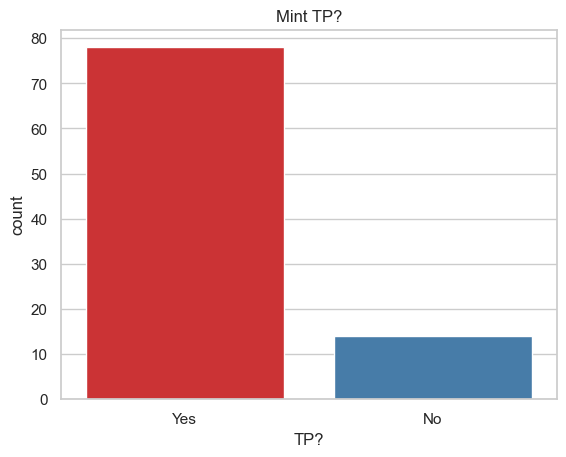

In [28]:
sns.countplot(x="TP?", data=mint_df, palette="Set1")
plt.title("Mint TP?")

#### leak

Text(0.5, 1.0, 'Leak TP?')

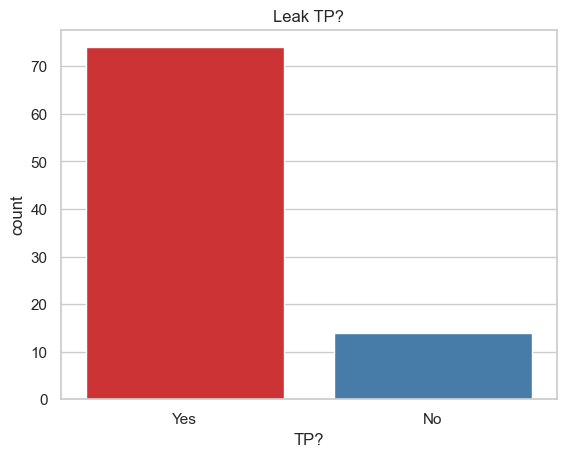

In [29]:
sns.countplot(x="TP?", data=leak_df, palette="Set1")
plt.title("Leak TP?")

Text(0.5, 1.0, 'Limit TP?')

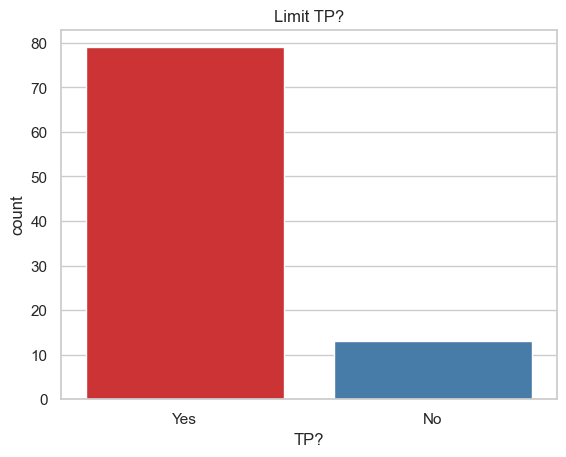

In [30]:
sns.countplot(x="TP?", data=limit_df, palette="Set1")
plt.title("Limit TP?")

### Missing Value

In [31]:
mint_df.isna().sum()

Address    0
TP?        0
dtype: int64

In [32]:
leak_df.isna().sum()

Address    0
TP?        0
dtype: int64

In [33]:
limit_df.isna().sum()

Address    0
TP?        0
dtype: int64

In [34]:
large_mint_hex_missing = set(mint_df['Address']) - set(large_hex_file_list)
print(f"Missing HEX files for large mint: {len(large_mint_hex_missing)}")

Missing HEX files for large mint: 0


In [35]:
large_leak_hex_missing = set(leak_df['Address']) - set(large_hex_file_list)
print(f"Missing HEX files for large leak: {len(large_leak_hex_missing)}")

Missing HEX files for large leak: 0


In [36]:
large_limit_hex_missing = set(limit_df['Address']) - set(large_hex_file_list)
print(f"Missing HEX files for large limit: {len(large_limit_hex_missing)}")

Missing HEX files for large limit: 0


#### Get Source Code

In [37]:
PATH_LARGE_SOL = f"{PATH_LARGE}/sol"
os.makedirs(PATH_LARGE_SOL, exist_ok=True)

In [38]:
larger_hex_list = [os.path.splitext(f)[0] for f in os.listdir(PATH_LARGE_HEX) if os.path.isfile(os.path.join(PATH_LARGE_HEX, f))]
print(f"Total HEX files in large: {len(larger_hex_list)}")

Total HEX files in large: 13483


In [39]:
for address in larger_hex_list:
    for chain_id in chains:
        result = get_source_code(address, chain_id)
        if result and result["SourceCode"].strip():
            filename = f"{PATH_LARGE_SOL}/{address}.sol"
            with open(filename, "w", encoding="utf-8") as f:
                f.write(result["SourceCode"])
            print(f"Saved source code for {address} (chain {chain_id})")
            break

Saved source code for 0x71a982a028c9d4b0566041a78df12b810462e155 (chain 1)
Saved source code for 0x9b11efcaaa1890f6ee52c6bb7cf8153ac5d74139 (chain 1)
Saved source code for 0x9ec8d44af808d7cca2ec23c0dc0d1f49a3386ea4 (chain 1)
Saved source code for 0x662abcad0b7f345ab7ffb1b1fbb9df7894f18e66 (chain 1)
Saved source code for 0x21f15966e07a10554c364b988e91dab01d32794a (chain 1)
Saved source code for 0xff603f43946a3a28df5e6a73172555d8c8b02386 (chain 1)
Saved source code for 0x14ddda446688b73161aa1382f4e4343353af6fc8 (chain 1)
Saved source code for 0x5d3d1598e70a2fce9ebe13ac613185da05febbe8 (chain 1)
Saved source code for 0x9954ff0295443c01f562dccb1f893be464e01986 (chain 1)
Saved source code for 0x50b676fa034b9afe83e05968f2b76aef2c35228d (chain 1)
Saved source code for 0x7d5902d64e4ed8c60f7c3e2ad1a0aaddd54a6e3f (chain 1)
Saved source code for 0x765f0c16d1ddc279295c1a7c24b0883f62d33f75 (chain 1)
Saved source code for 0x130a977156102c0fe5e9075594c03c51bf1be746 (chain 1)
Saved source code for 0x2

In [40]:
# check large/hex and large/sol
if len(larger_hex_list) == len(os.listdir(PATH_LARGE_SOL)):
    print("All HEX files have corresponding SOL files in large directory.")
else:
    print("Mismatch between HEX and SOL files in large directory.")

Mismatch between HEX and SOL files in large directory.


In [41]:
len(os.listdir(PATH_LARGE_SOL))

13482

In [42]:
len(os.listdir(PATH_LARGE_HEX))

13483

In [57]:
large_hex_address_list = [os.path.splitext(f)[0] for f in os.listdir(PATH_LARGE_HEX) if os.path.isfile(os.path.join(PATH_LARGE_HEX, f))]
large_sol_address_list = [os.path.splitext(f)[0] for f in os.listdir(PATH_LARGE_SOL) if os.path.isfile(os.path.join(PATH_LARGE_SOL, f))]

missing_sol = set(large_hex_address_list) - set(large_sol_address_list)
print(f"Missing HEX files in large directory: {len(missing_sol)}")

Missing HEX files in large directory: 1


In [58]:
missing_sol

{'0x14aa9c36d76901fe1ebcc860038aee9318596103'}

In [59]:
for address in missing_sol:
    for chain_id in chains:
        result = get_source_code(address, chain_id)
        if result and result["SourceCode"].strip():
            filename = f"{PATH_LARGE_SOL}/{address}.sol"
            with open(filename, "w", encoding="utf-8") as f:
                f.write(result["SourceCode"])
            print(f"Saved source code for {address} (chain {chain_id})")
            break

In [61]:
large_df = pd.concat([mint_df, leak_df, limit_df], ignore_index=True)

large_df[large_df["Address"].isin(missing_sol)]

,Address,TP?


**Note:**

"0x14aa9c36d76901fe1ebcc860038aee9318596103" <--- This address is the one which has bytecode, but the code was not verified